In [405]:
import matplotlib.pyplot as plt
import numpy.matlib
import time

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [479]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import numpy.matlib

class Params:
    '''
    example: params=Params(mu=2)
    '''
    def __init__(self,
    delta=0,    
    L=100,
    T=0,
    bc=1    # 0: open boundary condition; >0: PBC; <0: APBC
    ):
        self.delta=delta
        self.mu=2*(1-delta)
        self.t=-(1+delta)
        self.Delta=-(1+delta)
        self.L=L
        self.tau_z=sp.dia_matrix(np.diag([1,-1]))
        self.tau_y=sp.dia_matrix(np.array([[0,-1j],[1j,0]]))
        self.bc=bc
        self.T=T
        self.band1sm=sp.diags([1],[1],(L,L)).tocsr()
        self.bandm1sm=sp.diags([1],[-1],(L,L)).tocsr()
        self.band1sm[-1,0]=1*(2*np.heaviside(bc,1/2)-1)
        self.bandm1sm[0,-1]=1*(2*np.heaviside(bc,1/2)-1)
        # Hamiltonian in the ferimion basis
        self.Hamiltonian_f=-self.mu*sp.kron(self.tau_z,sp.identity(self.L))-sp.kron(self.t*self.tau_z+1j*self.Delta*self.tau_y,self.band1sm)-sp.kron(self.t*self.tau_z-1j*self.Delta*self.tau_y,self.bandm1sm)
        # BdG Hamiltonian back to original
        
        self.Hamiltonian_f/=2
        # Hamiltonian in the Majorana basis
        band=np.vstack([np.ones(L)*(1-delta)*1j,np.ones(L)*(1+delta)*1j]).flatten('F')
        Ham=sp.diags(np.array([band[:-1],band[:-1].conj()]),np.array([-1,1]),shape=(2*L,2*L)).tocsr()
        Ham[0,-1]=(1+delta)*1j*bc
        Ham[-1,0]=-(1+delta)*1j*bc
        self.Hamiltonian_m=Ham

        


    def bandstructure(self,H_type='f'):    
        if H_type=='f':    
            val,vec=la.eigh(self.Hamiltonian_f.toarray())
            sortindex=np.argsort(val)
            self.val_f=val[sortindex]
            self.vec_f=vec[:,sortindex]
        elif H_type=='m':
            val,vec=la.eigh(self.Hamiltonian_m.toarray()) 
            sortindex=np.argsort(val)
            self.val_m=val[sortindex]
            self.vec_m=vec[:,sortindex]
        else:
            raise ValueError('type of Hamiltonian ({}) not found'.format(H_type))



    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T)) 


    def covariance_matrix_f(self,E_F=0):
        if not (hasattr(self,'val_f') and hasattr(self,'vec_f')):
            self.bandstructure('f')
        occupancy=self.fermi_dist(self.val_f,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_f.shape[0],1)
        self.C_f=np.real((occupancy_mat*self.vec_f)@self.vec_f.T.conj())

    def covariance_matrix_m(self,E_F=0):
        if not (hasattr(self,'val_m') and hasattr(self,'vec_m')):
            self.bandstructure('m')
        occupancy=self.fermi_dist(self.val_m,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_m.shape[0],1)
        self.C_m=(1j*2*(occupancy_mat*self.vec_m)@self.vec_m.T.conj())-1j*np.eye(self.L*2)
        assert np.abs(np.imag(self.C_m)).max()<1e-10, "Covariance matrix not real"
        self.C_m=np.real(self.C_m)
        self.C_m_history=[self.C_m]
    
    def projection(self,s):
        '''
        s= 0,1 occupancy number
        i,j: adjacent pair of Majorana
        flow is from alpha_{i,j} to gamma_{i,j}

        return: the basis are ordered as gamma_i,gamma_j,alpha_j,alpha_i
        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=(np.array([[0,-(-1)**s],[(-1)**s,0]]))
        return sp.bmat([[blkmat,None],[None,blkmat.T]]).toarray()

    def measure(self,s,i,j):
        permutation_mat=sp.diags([1],[0],(self.L*2,self.L*2)).tocsr()
        # i <-> -2
        permutation_mat[i,i]=0
        permutation_mat[-2,-2]=0
        permutation_mat[i,-2]=1
        permutation_mat[-2,i]=1
        # j <-> -1
        permutation_mat[j,j]=0
        permutation_mat[-1,-1]=0
        permutation_mat[j,-1]=1
        permutation_mat[-1,j]=1
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()
        C_m_perm=permutation_mat.T@self.C_m_history[-1]@permutation_mat.T
        Gamma_LL=C_m_perm[:-2,:-2]
        Gamma_LR=C_m_perm[:-2,-2:]
        Gamma_RR=C_m_perm[-2:,-2:]

        proj=self.projection(s)
        Upsilon_LL=proj[:-2,:-2]
        Upsilon_LR=proj[:-2,-2:]
        Upsilon_RR=proj[-2:,-2:]
        Upsilon_RL=proj[-2:,:-2]
        zero=np.zeros((self.L*2-2,2))
        zero0=np.zeros((2,2))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
        else:
            Psi=mat1
        Psi=permutation_mat.T@Psi@permutation_mat
        
        
        self.C_m_history.append(Psi) 


    def c_subregion_f(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix_f()
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask_hh=np.isin(XX,subregion)*np.isin(YY,subregion)
        mask_hp=np.isin(XX,subregion)*np.isin(YY,subregion+self.L)
        mask_ph=np.isin(XX,subregion+self.L)*np.isin(YY,subregion)
        mask_pp=np.isin(XX,subregion+self.L)*np.isin(YY,subregion+self.L)
        mask=mask_hh+mask_hp+mask_ph+mask_pp
        return self.C_f[mask].reshape((2*subregion.shape[0],2*subregion.shape[0]))

    def von_Neumann_entropy(self,subregion):
        c_A=self.c_subregion(subregion)
        val,vec=la.eigh(c_A)
        self.val_sh=val
        val=np.sort(val)[:subregion.shape[0]]
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()

        if Gamma==None:
            Gamma=self.C_m_history[-1]
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask=np.isin(XX,subregion)*np.isin(YY,subregion)        
        return Gamma[mask].reshape((subregion.shape[0],subregion.shape[0]))

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val,vec=la.eigh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))/2

    def mutual_information(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy(subregion_A)
        s_B=self.von_Neumann_entropy(subregion_B)
        subregion_AB=np.hstack([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.hstack([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def measure_batch(self,batchsize,proj_range):
        self.i_history=[]
        self.s_history=[]
        for _ in range(batchsize):
            i=np.random.randint(*proj_range)
            s=np.random.randint(0,2)
            self.i_history.append(i)
            self.s_history.append(s)
            self.measure(s,i,i+1)

    def measure_all(self,s):
        self.i_history=[]
        self.s_history=[]
        # proj_range=np.hstack([np.arange(int(self.L/2),self.L,2),np.arange(int(self.L/2),self.L,2)+self.L])
        proj_range=np.hstack([np.arange(int(self.L/2),self.L,2)]) 
        # proj_range=np.hstack([np.arange(int(self.L/2),self.L)])
        # proj_range=np.hstack([np.arange(int(self.L/2),self.L),np.arange(int(self.L/2),int(self.L/2)+2)+self.L])
        for i in proj_range:
            self.i_history.append(i)
            self.s_history.append(s)
            self.measure(s,i,i+1)

    def measure_all_random(self,batchsize,proj_range):
        self.i_history=[]
        self.s_history=[]        
        # if batchsize>proj_range.shape[0]:
        #     raise ValueError("The batchsize {} cannot be larger than the proj_range {}".format(batchsize,proj_range.shape[0]))
        choice=np.random.choice(range(*proj_range),batchsize,replace=False)
        for i in choice:
            s=np.random.randint(0,2)
            self.i_history.append(i)  
            self.s_history.append(s)
            self.measure(s,i,i+1)      


    def measure_all_random_even(self,batchsize,proj_range):
        self.i_history=[]
        self.s_history=[]        
        # if batchsize>proj_range.shape[0]:
        #     raise ValueError("The batchsize {} cannot be larger than the proj_range {}".format(batchsize,proj_range.shape[0]))
        # choice=np.random.choice(range(*proj_range),batchsize,replace=False)
        proj_range_even=[i//2 for i in proj_range]
        choice=np.random.choice(range(*proj_range_even),batchsize,replace=False)
        for i in choice:
            s=np.random.randint(0,2)
            self.i_history.append(2*i)  #only even is accepted 
            self.s_history.append(s)
            self.measure(s,2*i,2*i+1)  
        

In [586]:
params=Params(delta=-0.3,L=16,bc=0)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
params.bandstructure('f')
params.val

array([-2.00000000e+00, -1.96157056e+00, -1.96157056e+00, -1.84775907e+00,
       -1.84775907e+00, -1.66293922e+00, -1.66293922e+00, -1.41421356e+00,
       -1.41421356e+00, -1.11114047e+00, -1.11114047e+00, -7.65366865e-01,
       -7.65366865e-01, -3.90180644e-01, -3.90180644e-01,  1.47709056e-16,
        2.77699819e-15,  3.90180644e-01,  3.90180644e-01,  7.65366865e-01,
        7.65366865e-01,  1.11114047e+00,  1.11114047e+00,  1.41421356e+00,
        1.41421356e+00,  1.66293922e+00,  1.66293922e+00,  1.84775907e+00,
        1.84775907e+00,  1.96157056e+00,  1.96157056e+00,  2.00000000e+00])

In [ ]:
params.bandstructure('m')
params.val

array([-2.00000000e+00, -1.96157056e+00, -1.96157056e+00, -1.84775907e+00,
       -1.84775907e+00, -1.66293922e+00, -1.66293922e+00, -1.41421356e+00,
       -1.41421356e+00, -1.11114047e+00, -1.11114047e+00, -7.65366865e-01,
       -7.65366865e-01, -3.90180644e-01, -3.90180644e-01,  1.33226763e-15,
        3.33066907e-15,  3.90180644e-01,  3.90180644e-01,  7.65366865e-01,
        7.65366865e-01,  1.11114047e+00,  1.11114047e+00,  1.41421356e+00,
        1.41421356e+00,  1.66293922e+00,  1.66293922e+00,  1.84775907e+00,
        1.84775907e+00,  1.96157056e+00,  1.96157056e+00,  2.00000000e+00])

In [ ]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=-1)
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


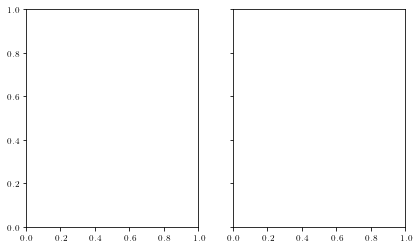

In [518]:
fig,ax=plt.subplots(1,2,sharey=True)
# for index in range(eigvallist_f[0].shape[0]):
#     ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
#     ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
# [ax.set_xlabel(r'$\delta$') for ax in ax]
# ax[0].set_ylabel(r'$E$')
# [ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]

# fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-apbc.pdf',bbox_inches='tight')


In [514]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=0)
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


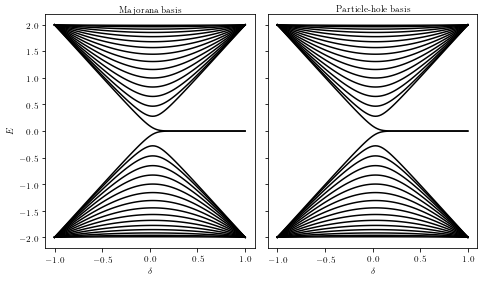

In [525]:
fig,ax=plt.subplots(1,2,sharey=True)
for index in range(eigvallist_m[0].shape[0]):
    ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
    ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
[ax.set_xlabel(r'$\delta$') for ax in ax]
ax[0].set_ylabel(r'$E$')
[ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-obc.pdf',bbox_inches='tight')


In [3]:
params=Params(delta=0.3,L=16,bc=-1)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [4]:
params.covariance_matrix_m()
params.covariance_matrix_f()

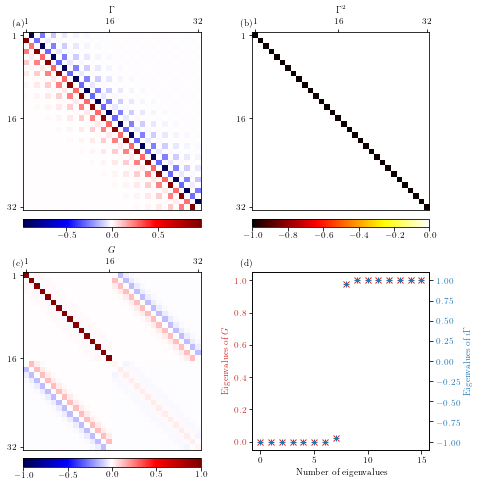

In [675]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,16,32]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,16,32]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/3/cov.pdf',bbox_inches='tight')


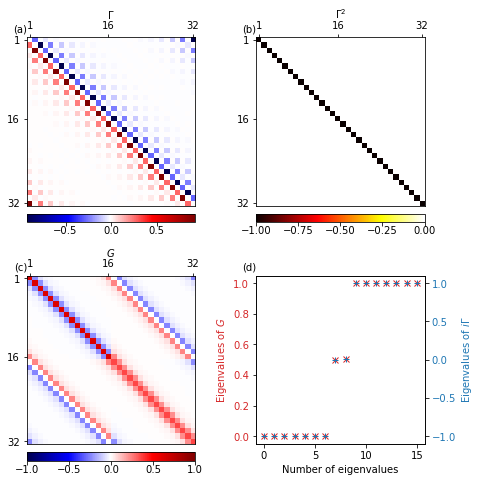

In [10]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,16,32]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,16,32]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/4/cov.pdf',bbox_inches='tight')


In [8]:
l=8
val_sub={}
val_sub['f']=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
val_sub['m']=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

In [646]:
val_sub['f']

array([-1.81920941e-16, -9.85288403e-17, -2.58276871e-17,  4.59352493e-16,
        1.85260598e-12,  4.43848341e-09,  9.77989783e-06,  2.09394658e-02,
        9.79060534e-01,  9.99990220e-01,  9.99999996e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

In [647]:
val_sub['m']

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.99999999, -0.99998044, -0.95812107,  0.95812107,  0.99998044,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ])

In [648]:
(1+val_sub['m'])/2

array([-3.88578059e-15,  2.77555756e-16,  1.11022302e-15,  1.07691633e-14,
        1.85301774e-12,  4.43848008e-09,  9.77989782e-06,  2.09394658e-02,
        9.79060534e-01,  9.99990220e-01,  9.99999996e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

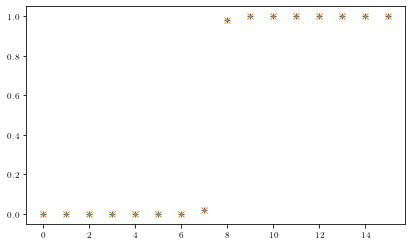

In [649]:
fig,ax=plt.subplots()
plt.plot(((1+val_sub['m'])/2),'.',marker="+")
plt.plot(val_sub['f'],'.',marker="x")
# plt.plot(val_sub['m'],'.',marker="x")


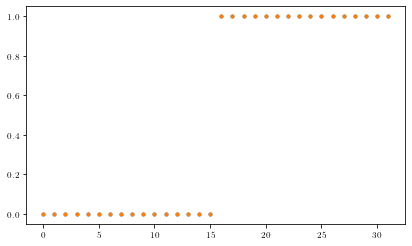

In [607]:
plt.plot(np.sort((1-val['m'])/2),'.')
plt.plot(val['f'],'.')

In [592]:
la.eigh(1j*params.c_subregion_m(np.arange(8)),eigvals_only=True)

array([-1.        , -0.99999999, -0.99998109, -0.95814734,  0.95814734,
        0.99998109,  0.99999999,  1.        ])

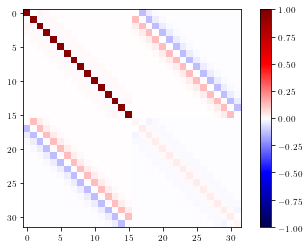

In [618]:
fig,ax=plt.subplots()
im=ax.imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
cb=fig.colorbar(im)

In [577]:
val={}
val['f']=la.eigh(params.C_f,eigvals_only=True)
val['m']=la.eigh(1j*params.C_m,eigvals_only=True)

In [578]:
val['f']

array([-2.53676396e-16, -2.00261838e-16, -1.73738609e-16, -1.58024122e-16,
       -1.16524714e-16, -9.14279475e-17, -8.19844432e-17, -6.77188529e-17,
       -2.10810584e-17,  1.32900594e-17,  3.78031436e-17,  1.17016287e-16,
        1.28022536e-16,  1.84327360e-16,  2.33521206e-16,  2.51895052e-16,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

In [580]:
(1-val['m'])/2

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        8.88178420e-16,  7.77156117e-16,  4.99600361e-16,  3.88578059e-16,
        2.77555756e-16,  2.77555756e-16,  1.11022302e-16,  1.11022302e-16,
        0.00000000e+00, -1.11022302e-16, -2.22044605e-16, -3.33066907e-16,
       -4.44089210e-16, -5.55111512e-16, -8.88178420e-16, -8.88178420e-16])

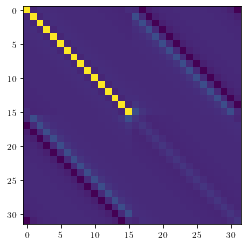

In [565]:
plt.imshow(params.C_f)

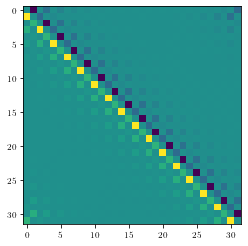

In [564]:
plt.imshow(params.C_m)

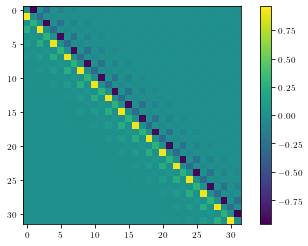

In [167]:
plt.imshow(params.C_m)
plt.colorbar()

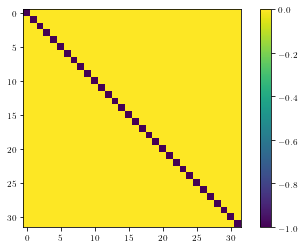

In [168]:
plt.imshow(params.C_m@params.C_m)
plt.colorbar()

In [169]:
ld=la.eigh(params.C_f,eigvals_only=True)

In [170]:
ld

array([-2.26234955e-16, -1.79490803e-16, -1.49898842e-16, -1.08827097e-16,
       -9.69112322e-17, -8.63455613e-17, -5.61039384e-17,  6.62169059e-19,
        4.85762416e-17,  6.39493863e-17,  7.96614272e-17,  9.21165981e-17,
        1.14763722e-16,  1.36466229e-16,  1.94051923e-16,  2.58155090e-16,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

In [156]:
xi=la.eigh(1j*params.C_m,eigvals_only=True)

In [157]:
(1-xi)/2

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        8.88178420e-16,  7.77156117e-16,  4.99600361e-16,  3.88578059e-16,
        2.77555756e-16,  2.77555756e-16,  1.11022302e-16,  1.11022302e-16,
        0.00000000e+00, -1.11022302e-16, -2.22044605e-16, -3.33066907e-16,
       -4.44089210e-16, -5.55111512e-16, -8.88178420e-16, -8.88178420e-16])

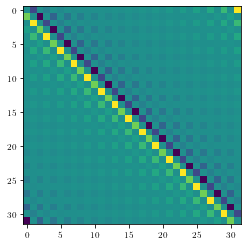

In [90]:
plt.imshow(params.C_m)

In [78]:
np.real(np.round(params.C_m,10)-0.5*np.eye(32))

array([[ 0., -0.,  0., ...,  0.,  0., -0.],
       [-0.,  0., -0., ..., -0.,  0.,  0.],
       [ 0., -0.,  0., ..., -0., -0.,  0.],
       ...,
       [ 0., -0., -0., ...,  0., -0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0.,  0.]])

In [68]:
np.round(params.C_m@params.C_m,10)

array([[-0.        +0.j        , -0.        -0.45313889j,
         0.        +0.j        , ...,  0.        +0.28729939j,
         0.        -0.j        , -0.        +0.80502279j],
       [-0.        -0.45313889j, -1.50915585-0.17789597j,
        -0.15422977+0.32473775j, ..., -0.18692331+0.04011071j,
         0.15422977+0.3803277j ,  0.40159976-0.14555125j],
       [ 0.        +0.j        , -0.15422977+0.32473775j,
        -0.51550493+0.1591981j , ...,  0.08846286+0.44832896j,
         0.51550493-0.1591981j , -0.12618799-0.10566109j],
       ...,
       [ 0.        +0.28729939j, -0.18692331+0.04011071j,
         0.08846286+0.44832896j, ..., -1.71233948-0.12723643j,
        -0.08846286+0.52379187j, -0.15293725+0.03281786j],
       [ 0.        -0.j        ,  0.15422977+0.3803277j ,
         0.51550493-0.1591981j , ..., -0.08846286+0.52379187j,
        -0.51550493+0.1591981j ,  0.12618799-0.06017841j],
       [-0.        +0.80502279j,  0.40159976-0.14555125j,
        -0.12618799-0.10566109

In [5]:
params.bandstructure('f')
params.bandstructure('m')

In [11]:
params.vec_f[:,15].reshape((2,-1))

array([[ 0.00000000e+00+0.j,  2.10248485e-15+0.j,  2.55351296e-15+0.j,
         2.99760217e-15+0.j,  2.16493490e-15+0.j,  1.11022302e-15+0.j,
         1.94289029e-16+0.j,  5.55111512e-17+0.j,  1.24900090e-16+0.j,
         2.08166817e-16+0.j, -1.04083409e-16+0.j, -1.06250684e-15+0.j,
        -2.09435032e-15+0.j, -2.99028005e-15+0.j, -2.52307756e-15+0.j,
        -2.10165531e-15+0.j],
       [ 2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         2.50000000e-01+0.j]])

In [34]:
zz=np.kron(1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]),np.eye(16))@params.vec_f[:,16]

In [41]:
la.det(np.kron(np.eye(16),1/np.sqrt(2)*np.array([[1,1],[1j,-1j]])))

(0.9999999999999974+0j)

In [ ]:
np.kron(np.eye(16),1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]))

In [42]:
np.kron(1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]),np.eye(16))@params.vec_f[:,15]

array([0.1767767+0.j       , 0.1767767+0.j       , 0.1767767+0.j       ,
       0.1767767+0.j       , 0.1767767+0.j       , 0.1767767+0.j       ,
       0.1767767+0.j       , 0.1767767+0.j       , 0.1767767+0.j       ,
       0.1767767+0.j       , 0.1767767+0.j       , 0.1767767+0.j       ,
       0.1767767+0.j       , 0.1767767+0.j       , 0.1767767+0.j       ,
       0.1767767+0.j       , 0.       -0.1767767j, 0.       -0.1767767j,
       0.       -0.1767767j, 0.       -0.1767767j, 0.       -0.1767767j,
       0.       -0.1767767j, 0.       -0.1767767j, 0.       -0.1767767j,
       0.       -0.1767767j, 0.       -0.1767767j, 0.       -0.1767767j,
       0.       -0.1767767j, 0.       -0.1767767j, 0.       -0.1767767j,
       0.       -0.1767767j, 0.       -0.1767767j])

In [48]:
params.vec_f[:,15]

array([ 0.00000000e+00+0.j,  2.10248485e-15+0.j,  2.55351296e-15+0.j,
        2.99760217e-15+0.j,  2.16493490e-15+0.j,  1.11022302e-15+0.j,
        1.94289029e-16+0.j,  5.55111512e-17+0.j,  1.24900090e-16+0.j,
        2.08166817e-16+0.j, -1.04083409e-16+0.j, -1.06250684e-15+0.j,
       -2.09435032e-15+0.j, -2.99028005e-15+0.j, -2.52307756e-15+0.j,
       -2.10165531e-15+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        2.50000000e-01+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        2.50000000e-01+0.j,  2.50000000e-01+0.j])

In [50]:
np.kron(np.eye(16),1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]))@params.vec_f[:,15].reshape((2,-1)).flatten('F')

array([0.1767767+0.j       , 0.       -0.1767767j, 0.1767767+0.j       ,
       0.       -0.1767767j, 0.1767767+0.j       , 0.       -0.1767767j,
       0.1767767+0.j       , 0.       -0.1767767j, 0.1767767+0.j       ,
       0.       -0.1767767j, 0.1767767+0.j       , 0.       -0.1767767j,
       0.1767767+0.j       , 0.       -0.1767767j, 0.1767767+0.j       ,
       0.       -0.1767767j, 0.1767767+0.j       , 0.       -0.1767767j,
       0.1767767+0.j       , 0.       -0.1767767j, 0.1767767+0.j       ,
       0.       -0.1767767j, 0.1767767+0.j       , 0.       -0.1767767j,
       0.1767767+0.j       , 0.       -0.1767767j, 0.1767767+0.j       ,
       0.       -0.1767767j, 0.1767767+0.j       , 0.       -0.1767767j,
       0.1767767+0.j       , 0.       -0.1767767j])

In [74]:
np.round(params.vec_m@params.vec_m.T.conj(),10)

array([[ 1.+0.j, -0.-0.j,  0.-0.j, ...,  0.-0.j,  0.+0.j, -0.+0.j],
       [-0.+0.j,  1.+0.j, -0.-0.j, ..., -0.+0.j,  0.-0.j,  0.+0.j],
       [ 0.+0.j, -0.+0.j,  1.+0.j, ..., -0.+0.j, -0.-0.j,  0.-0.j],
       ...,
       [ 0.+0.j, -0.-0.j, -0.-0.j, ...,  1.+0.j, -0.-0.j,  0.-0.j],
       [ 0.-0.j,  0.+0.j, -0.+0.j, ..., -0.+0.j,  1.+0.j, -0.-0.j],
       [-0.-0.j,  0.-0.j,  0.+0.j, ...,  0.+0.j, -0.+0.j,  1.+0.j]])

In [33]:
np.round((params.vec_m[:,16]),10)

array([ 0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767+0.j       ,  0.       -0.1767767j,
        0.1767767+0.j       ,  0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767-0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j,
        0.1767767+0.j       , -0.       -0.1767767j])

In [ ]:
params.vec_f[:,-16].reshape((2,-1))

array([[0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j,
        0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j,
        0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j,
        0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j, 0.2499315+0.j],
       [0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j,
        0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j,
        0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j,
        0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j, 0.0058519+0.j]])

In [15]:
params.val_f[16]

0.20000000000000262

In [ ]:
params.Hamiltonian_f

<32x32 sparse matrix of type '<class 'numpy.complex128'>'
	with 160 stored elements in Compressed Sparse Row format>

In [12]:
params.val_f

array([-2.        , -1.96195858, -1.96195858, -1.84934351, -1.84934351,
       -1.66664729, -1.66664729, -1.42126704, -1.42126704, -1.12351538,
       -1.12351538, -0.78735543, -0.78735543, -0.43671332, -0.43671332,
       -0.2       ,  0.2       ,  0.43671332,  0.43671332,  0.78735543,
        0.78735543,  1.12351538,  1.12351538,  1.42126704,  1.42126704,
        1.66664729,  1.66664729,  1.84934351,  1.84934351,  1.96195858,
        1.96195858,  2.        ])

In [13]:
params.val_m

array([-2.        , -1.96195858, -1.96195858, -1.84934351, -1.84934351,
       -1.66664729, -1.66664729, -1.42126704, -1.42126704, -1.12351538,
       -1.12351538, -0.78735543, -0.78735543, -0.43671332, -0.43671332,
       -0.2       ,  0.2       ,  0.43671332,  0.43671332,  0.78735543,
        0.78735543,  1.12351538,  1.12351538,  1.42126704,  1.42126704,
        1.66664729,  1.66664729,  1.84934351,  1.84934351,  1.96195858,
        1.96195858,  2.        ])

In [179]:
np.outer(np.array([1,0]),np.array([0,1]))

array([[0, 1],
       [0, 0]])

In [232]:
z=sp.diags([1],[0],(6,6)).tocsr()
z[2,2]=0
z[2,-2]=1
z[-2,-2]=0
z[-2,2]=1
z[3,3]=0
z[3,-1]=1
z[-1,-1]=0
z[-1,3]=1

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [222]:
z.toarray()

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [223]:
m=np.arange(6*6).reshape((6,-1))

In [224]:
m

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [228]:
m1=z.T@m@z

In [229]:
m1

array([[ 0.,  1.,  2.,  5.,  4.,  3.],
       [ 6.,  7.,  8., 11., 10.,  9.],
       [12., 13., 14., 17., 16., 15.],
       [30., 31., 32., 35., 34., 33.],
       [24., 25., 26., 29., 28., 27.],
       [18., 19., 20., 23., 22., 21.]])

In [230]:
z=sp.diags([1],[0],(6,6)).tocsr()
z[2,2]=0
z[2,-2]=1
z[-2,-2]=0
z[-2,2]=1

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [231]:
z.T@m1@z

array([[ 0.,  1.,  4.,  5.,  2.,  3.],
       [ 6.,  7., 10., 11.,  8.,  9.],
       [24., 25., 28., 29., 26., 27.],
       [30., 31., 34., 35., 32., 33.],
       [12., 13., 16., 17., 14., 15.],
       [18., 19., 22., 23., 20., 21.]])

In [233]:
z.T@m@z

array([[ 0.,  1.,  4.,  5.,  2.,  3.],
       [ 6.,  7., 10., 11.,  8.,  9.],
       [24., 25., 28., 29., 26., 27.],
       [30., 31., 34., 35., 32., 33.],
       [12., 13., 16., 17., 14., 15.],
       [18., 19., 22., 23., 20., 21.]])

In [227]:
z.T@m1@z

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35.]])

In [235]:
m1_LL=m1[:-2,:-2]
m1_LR=m1[:-2,-2:]
m1_RR=m1[-2:,-2:]

In [238]:
m1

array([[ 0.,  1.,  2.,  5.,  4.,  3.],
       [ 6.,  7.,  8., 11., 10.,  9.],
       [12., 13., 14., 17., 16., 15.],
       [30., 31., 32., 35., 34., 33.],
       [24., 25., 26., 29., 28., 27.],
       [18., 19., 20., 23., 22., 21.]])

In [237]:
m1_LL

array([[ 0.,  1.,  2.,  5.],
       [ 6.,  7.,  8., 11.],
       [12., 13., 14., 17.],
       [30., 31., 32., 35.]])

In [236]:
m1_LR

array([[ 4.,  3.],
       [10.,  9.],
       [16., 15.],
       [34., 33.]])

In [239]:
m1_RR

array([[28., 27.],
       [22., 21.]])

In [244]:
mm=np.arange(4).reshape((2,-1))+1

In [246]:
mm2=mm+1

In [248]:
la.inv(mm2)@mm

array([[ 2.,  1.],
       [-1.,  0.]])

In [249]:
la.solve(mm2,mm)

array([[ 2.,  1.],
       [-1.,  0.]])

In [277]:
params.measure(0,10,11)

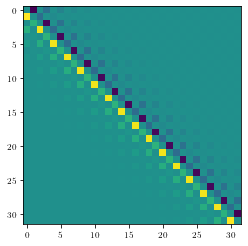

In [275]:

plt.imshow(params.C_m_history[0])

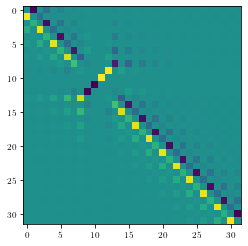

In [276]:
plt.imshow(params.C_m_history[1])

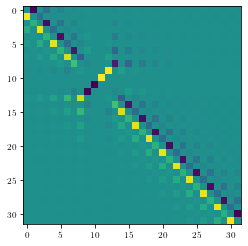

In [278]:
plt.imshow(params.C_m_history[2])

In [279]:
params.C_m_history[1]-params.C_m_history[2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [280]:
params.measure(0,20,21)

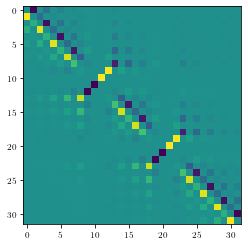

In [281]:
plt.imshow(params.C_m_history[-1])

In [295]:
params.measure(0,10,11)

In [296]:
params.von_Neumann_entropy_m(np.arange(2))

0.2662253391049969

In [291]:
params.val_sh

array([-0.96231518, -0.92299796,  0.92299796,  0.96231518])

In [303]:
np.arange(2)

array([0, 1])

In [310]:
params.mutual_information_m(np.arange(2),np.arange(2)+30)

1.0114155069018693e-09

# Mutual information

In [33]:
delta_list=np.linspace(-1,1,20)
mutual_info_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    mutual_info_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


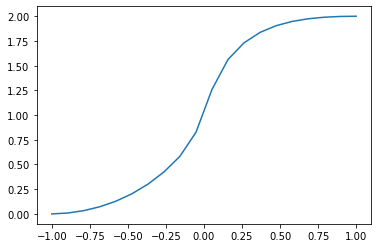

In [35]:
plt.plot(delta_list,mutual_info_list/np.log(2))

In [474]:
st=time.time()
params=Params(delta=delta,L=64,bc=-1)
params.measure_all_random_even(16,(int(params.L/2),params.L))
print(time.time()-st)

[16, 32]
0.08940625190734863


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [476]:
np.sort(params.i_history)

array([32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62])

In [477]:
params.s_history

[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]

In [504]:
def mutual_info_run(batchsize):
    delta_list=np.linspace(-1,1,50)**3
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=200

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=64,bc=-1)
            params.measure_all_random_even(batchsize,(int(params.L/2),params.L))
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

In [505]:
delta_dict={}
mutual_info_dis_dict={}
for i in (0,12,13,14,15,16):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

0


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


12
13
14
15
16


In [499]:
for i in (15,):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

15


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [500]:
delta_dict.keys()

dict_keys([0, 1, 8, 16, 12, 14, 15])

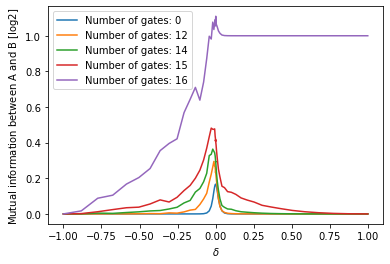

In [507]:
fig,ax=plt.subplots()
for i in (0,12,14,15,16):
    ax.plot(delta_dict[i],np.array(mutual_info_dis_dict[i]).mean(axis=1)/np.log(2),label='Number of gates: {}'.format(i))

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

fig.savefig('/mnt/d/kitp/Rp_SPT/4/mutual_info_Ap_En200.pdf',bbox_inches='tight')


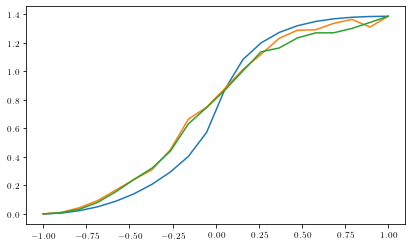

In [556]:
fig,ax=plt.subplots()
for i in (0,1000,3000):
    ax.plot(delta_dict[i],np.array(mutual_info_dis_dict[i]).mean(axis=1))


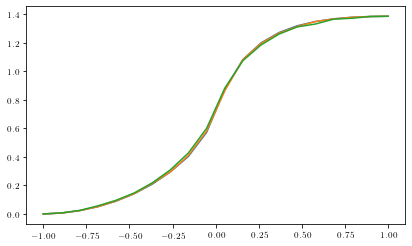

In [458]:
fig,ax=plt.subplots()
for i in (0,1,5):
    ax.plot(delta_dict[i],np.array(mutual_info_dis_dict[i]).mean(axis=1))


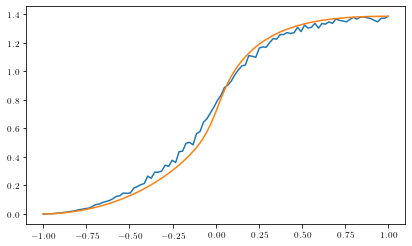

(100, 100)

In [441]:
np.array(mutual_info_dis_list).shape

In [ ]:
fig,ax=plt.subplots()
ax.plot(delta_list,np.array(mutual_info_dis_list).mean(axis=1))
ax.plot(delta_list,mutual_info_list)

In [338]:
for _ in range(10):
    i=np.random.randint(2,15)
    s=np.random.randint(0,2)
    params.measure(s,i,i+1)

In [54]:
params=Params(delta=-0.3,L=16,bc=-1)
params.measure_batch(10)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [55]:
params.i_history

[28, 10, 5, 20, 12, 14, 22, 23, 18, 23]

In [ ]:
fig,ax=plt.subplots(11,2,figsize=(3.4,10))

im_1=[ax[i,0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) for i,c_m in zip(range(11),params.C_m_history)]
im_2=[ax[i,1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) for i,c_m in zip(range(11),params.C_m_history)]

[ax[i,0].set_xticks([]) for i in range(11)]
[ax[i,0].set_yticks([]) for i in range(11)]
[ax[i,1].set_xticks([]) for i in range(11)]
[ax[i,1].set_yticks([]) for i in range(11)]

fig.savefig('/mnt/d/kitp/Rp_SPT/3/evolution.pdf',bbox_inches='tight')

# Measure all gates to intermedate region with same projection

In [142]:
L=32

In [143]:

np.hstack([np.arange(int(L/2),L,2),np.arange(int(L/2),L,2)+L])

array([16, 18, 20, 22, 24, 26, 28, 30, 48, 50, 52, 54, 56, 58, 60, 62])

In [449]:
params.i_history

[32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

In [96]:
params.s_history

[0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
delta_list=np.linspace(-1,1,200)
mutual_info_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    mutual_info_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))


In [454]:
params=Params(delta=-.99,L=64,bc=-1)
params.measure_all(0)

In [440]:
mutual_info_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    mutual_info_pos_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

-1.0


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


LinAlgError: Matrix is singular.

In [ ]:
mutual_info_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    mutual_info_neg_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


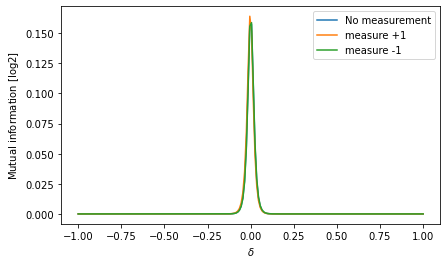

In [435]:
fig,ax=plt.subplots(figsize=(6.8,4))
ax.plot(delta_list,mutual_info_list/np.log(2),label='No measurement')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),label='measure +1')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),label='measure -1')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.savefig('/mnt/d/kitp/Rp_SPT/4/M_L64_ApBp_shared.pdf',bbox_inches='tight')

In [ ]:
def mutual_info_all_run(batchsize):
    delta_list=np.linspace(-1,1,40)
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=100

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=16,bc=-1)
            params.measure_batch(batchsize)    
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

# Evolution

In [333]:
params=Params(delta=0.3,L=32,bc=-1)
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)
# params.measure_batch(1,(params.L/2,params.L))
params.measure(1,20,21)
params.measure(0,25,26)
params.measure(1,40,41)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [274]:
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)

1.8106183219401828e-10

In [295]:
params.i_history

[21]

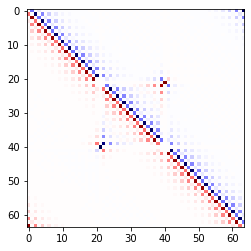

In [305]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(1,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

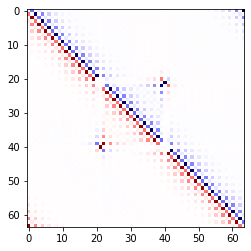

In [304]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(0,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

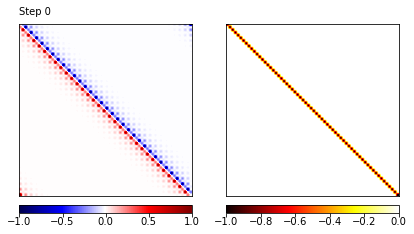

In [290]:
i=0
c_m=params.C_m_history[0]
fig,ax=plt.subplots(1,2,figsize=(6.8,10))

im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].text(0,1.05,'Step 0',transform=ax[0].transAxes)

axins0=ax[0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0].transAxes) 
cb0=fig.colorbar(im_1,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)
# cb0.ax.tick_params(labelsize=20)

axins1=ax[1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1].transAxes) 
cb1=fig.colorbar(im_2,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)
# cb1.ax.tick_params(labelsize=20)

# fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [276]:
%%capture
for i,c_m,s,ii in zip(range(1,21),params.C_m_history[1:],params.s_history,params.i_history):
    
    fig,ax=plt.subplots(1,2,figsize=(6.8,10))

    im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
    im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[0].text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',ii,ii+1),transform=ax[0].transAxes)

    # fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [277]:
tex_text="""
    \\begin{{figure}}[h]
        \\centering
        \\includegraphics[width=\\textwidth]{{evolution_trivial_{}.pdf}}
    \\end{{figure}}
    """

In [ ]:
string=""
for i in range(21):
    print(tex_text.format(i))

In [ ]:
print(string)

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m@c_m)

In [ ]:
plt.imshow(params.C_m_history[1])

In [ ]:
params.measure(0, 4, 5)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
params.measure(0, 4, 5)

In [ ]:
params.measure(1, 6, 7)

In [ ]:
params.measure(1, 4, 5)

In [ ]:
params=Params(delta=-0.3,L=16,bc=0)
params.mutual_information_m(np.arange(2),np.arange(2)+16)
params.measure_batch(100)

In [ ]:
params.mutual_information_m(np.arange(2),np.arange(2)+16)

0.0019446062606200964

In [ ]:
len(params.C_m_history)

4

In [ ]:
params.i_history

[13, 14, 3, 14]

In [ ]:
params.s_history

[1, 0, 0, 1]

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m)